In [1]:
import graphblas as gb
from graphblas import Matrix, Vector
from graphblas import unary, binary, monoid, semiring, dtypes

### Basic syntax

Let's examine some basic graphblas syntax

In [2]:
A = Matrix.from_coo(
    [0, 0, 1, 2, 2, 3, 4],
    [1, 2, 3, 3, 4, 4, 0],
    [1.1, 9.8, 4.2, 7.1, 0.2, 6.9, 2.2],
)
A

"M_0"      nvals  nrows  ncols  dtype   format
gb.Matrix      7      5      5   FP64  bitmapr
----------------------------------------------
     0    1    2    3    4
0       1.1  9.8          
1                 4.2     
2                 7.1  0.2
3                      6.9
4  2.2

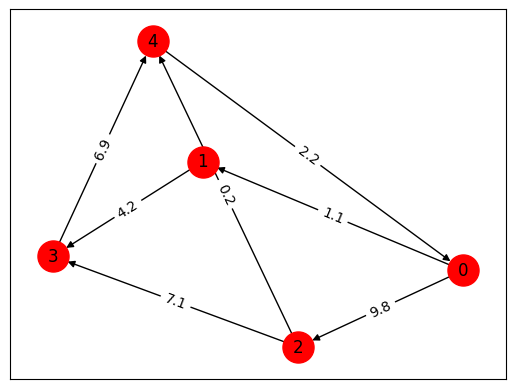

In [3]:
gb.viz.draw(A)

In [5]:
v = Vector(dtypes.FP64, 5)
v

"v_1"      nvals  size  dtype  format
gb.Vector      0     5   FP64  sparse
-------------------------------------
index 0 1 2 3 4
value

In [6]:
v << A.reduce_columnwise(monoid.max)
v

"v_1"      nvals  size  dtype  format
gb.Vector      5     5   FP64    full
-------------------------------------
index    0    1    2    3    4
value  2.2  1.1  9.8  7.1  6.9

In [7]:
A.mxv(v, semiring.min_plus).new(name="μ_0")

"μ_0"      nvals  size  dtype  format
gb.Vector      5     5   FP64    full
-------------------------------------
index    0     1    2     3    4
value  2.2  11.3  7.1  13.8  4.4

### Compare with C

Let's compare syntax from with the GraphBLAS C API.

This is an example from `LAGraph_pagerank3f`

```c++
GrB_Info LAGraph_pagerank3f // PageRank definition
(
    GrB_Vector *result,     // output: array of LAGraph_PageRank structs
    GrB_Matrix A,           // binary input graph, not modified
    GrB_Vector d_out,       // outbound degree of all nodes (not modified)
    float damping,          // damping factor (typically 0.85)
    int itermax,            // maximum number of iterations
    int *iters              // output: number of iterations taken
)
{

    //--------------------------------------------------------------------------
    // initializations
    //--------------------------------------------------------------------------

    GrB_Info info ;
    GrB_Index n ;
    GrB_Vector r = NULL, d = NULL, t = NULL, w = NULL ;
    (*result) = NULL ;
    LAGr_Matrix_nrows (&n, A) ;
    GrB_Descriptor desc_t0 = GrB_DESC_T0 ;

    const float teleport = (1 - damping) / n ;
    const float tol = 1e-4 ;
    float rdiff = 1 ;       // first iteration is always done

    // r = 1 / n
    LAGr_Vector_new (&t, GrB_FP32, n) ;
    LAGr_Vector_new (&r, GrB_FP32, n) ;
    LAGr_Vector_new (&w, GrB_FP32, n) ;
    LAGr_assign (r, NULL, NULL, 1.0 / n, GrB_ALL, n, NULL) ;

    // prescale with damping factor, so it isn't done each iteration
    // d = d_out / damping ;
    LAGr_Vector_dup (&d, d_out) ;
    LAGr_assign (d, NULL, GrB_DIV_FP32, damping, GrB_ALL, n, NULL) ;

    //--------------------------------------------------------------------------
    // pagerank iterations
    //--------------------------------------------------------------------------

    for ((*iters) = 0 ; (*iters) < itermax && rdiff > tol ; (*iters)++)
    {
        // swap t and r ; now t is the old score
        GrB_Vector temp = t ; t = r ; r = temp ;

        // w = t ./ d
        LAGr_eWiseMult (w, NULL, NULL, GrB_DIV_FP32, t, d, NULL) ;

        // r = teleport
        LAGr_assign (r, NULL, NULL, teleport, GrB_ALL, n, NULL) ;

        // r += A'*w
        LAGr_mxv (r, NULL, GrB_PLUS_FP32, GxB_PLUS_SECOND_FP32, A, w, desc_t0) ;

        // t -= r
        LAGr_assign (t, NULL, GrB_MINUS_FP32, r, GrB_ALL, n, NULL) ;

        // t = abs (t)
        LAGr_apply (t, NULL, NULL, GxB_ABS_FP32, t, NULL) ;

        // rdiff = sum (t)
        LAGr_reduce (&rdiff, NULL, GxB_PLUS_FP32_MONOID, t, NULL) ;
    }
```

In [11]:
def pagerank_3f(A, d_out, damping=0.85, itermax=100, tol=1e-4):
    """
    Returns (result as Vector, iters as int)
    """
    n = A.nrows
    teleport = (1 - damping) / n
    rdiff = 1  # first iteration is always done

    # r = 1 / n
    t = Vector(dtypes.FP32, n)
    r = Vector(dtypes.FP32, n)
    w = Vector(dtypes.FP32, n)
    r[:] << 1.0 / n

    # prescale with damping factor, so it isn't done each iteration
    # d = d_out / damping
    d = d_out.dup(dtype="FP32")
    d(accum=binary.truediv)[:] << damping

    # --------------------------------------------------------------------------
    # pagerank iterations
    # --------------------------------------------------------------------------
    for i in range(itermax):
        if rdiff <= tol:
            break

        # swap t and r ; now t is the old score
        r, t = t, r

        # w = t ./ d
        w << t.ewise_mult(d, binary.truediv)

        # r = teleport
        r[:] << teleport

        # r += A'*w
        r(binary.plus) << A.T.mxv(w, semiring.plus_second)

        # t -= r
        t(binary.minus)[:] << r

        # t = abs (t)
        t << t.apply(unary.abs)

        # rdiff = sum (t)
        rdiff = t.reduce(monoid.plus).value

    return r, i

In [ ]:
A

In [ ]:
# Pagerank requires binary input graph
A << A.apply(unary.one)
A

In [12]:
# Compute outbound degree of nodes
d_out = A.reduce_rowwise(monoid.plus).new()
d_out

"v_3"      nvals  size  dtype  format
gb.Vector      5     5   FP64    full
-------------------------------------
index     0    1    2    3    4
value  10.9  4.2  7.3  6.9  2.2

In [13]:
result, iters = pagerank_3f(A, d_out)

In [14]:
result

"v_4"      nvals  size  dtype  format
gb.Vector      5     5   FP32    full
-------------------------------------
index        0         1         2         3         4
value  0.04504  0.033514  0.033514  0.040687  0.038916

In [15]:
iters

7

### Compare with networkx for accuracy

In [ ]:
import networkx as nx

g = gb.io.to_networkx(A)
g.edges()

In [ ]:
nx.pagerank(g, tol=1e-4)

### Compare with networkx for speed

Need a larger graph for this test

In [ ]:
big = nx.erdos_renyi_graph(1000, 0.04, directed=True)

In [ ]:
%%timeit
pr = nx.pagerank(big, tol=1e-6)

In [ ]:
B = gb.io.from_networkx(big, dtype="UINT8")
B

In [ ]:
%%timeit
bd_out = B.reduce_rowwise(monoid.plus).new()
results, iter = pagerank_3f(B, bd_out, tol=1e-6)

In [ ]:
# timeit doesn't save variables, so recompute
pr = nx.pagerank(big, tol=1e-6)
bd_out = B.reduce_rowwise(monoid.plus).new()
results, iter = pagerank_3f(B, bd_out, tol=1e-6)

In [ ]:
iter

In [ ]:
results

In [ ]:
# Only look at first 10 results from networkx
{k: v for k, v in pr.items() if k < 10}

In [ ]:
# Verify all results match
all(abs(results[i].value - pr[i]) < 1e-5 for i in range(1000))